In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import json, folium, warnings
warnings.filterwarnings("ignore")

# Display settings
pd.set_option("display.max_columns", None)

In [3]:
from google.colab import files
uploaded = files.upload()

#load dataset
# Use the uploaded file name instead of the local path
data = pd.read_csv("air_quality_global.csv")

Saving air_quality_global.csv to air_quality_global.csv


In [4]:
from google.colab import files
uploaded = files.upload()

Saving metadata.json to metadata.json


In [6]:
df = pd.read_csv("air_quality_global.csv")
with open("metadata.json", "r") as f:
    metadata = json.load(f)

print("✅ Data Loaded")
print(df.shape)
df.head()

✅ Data Loaded
(6480, 11)


,city,country,latitude,longitude,year,month,pm25_ugm3,no2_ugm3,data_quality,measurement_method,data_source
0,New York,USA,40.7128,-74.006,1999,1,18.11,35.98,Moderate,Reference/Equivalent Method,EPA_AQS
1,New York,USA,40.7128,-74.006,1999,2,27.79,17.71,Good,Reference/Equivalent Method,EPA_AQS
2,New York,USA,40.7128,-74.006,1999,3,12.05,40.99,Moderate,Reference/Equivalent Method,EPA_AQS
3,New York,USA,40.7128,-74.006,1999,4,35.25,17.18,Poor,Reference/Equivalent Method,EPA_AQS
4,New York,USA,40.7128,-74.006,1999,5,38.39,25.07,Good,Reference/Equivalent Method,EPA_AQS


In [7]:
print("Dataset name:", metadata.get("dataset_name"))
print("Version:", metadata.get("version"))
print("Creation date:", metadata.get("creation_date"))
print("Total records (metadata):", metadata.get("total_records"))

# Check data quality & missing value codes
print("\nData quality notes:")
print(json.dumps(metadata.get("data_quality_notes", {}), indent=2))
print("\nMissing value codes:")
print(metadata.get("missing_value_codes", []))

Dataset name: Urban Air Quality and Climate Dataset (1958-2025)
Version: 1.0
Creation date: 2025-09-20
Total records (metadata): 17813

Data quality notes:
[
  "Real CO2 data from NOAA (first 100 records demonstrated)",
  "Air quality and climate data are representative samples based on real patterns",
  "All data includes quality flags and uncertainty estimates",
  "Missing data is explicitly marked with appropriate codes",
  "Seasonal and long-term trends reflect real-world patterns"
]

Missing value codes:
[]


In [8]:
#Data Cleaning
# Replace missing value codes with NaN
missing_codes = metadata.get("missing_value_codes", ["NA", "N/A", -999])
df.replace(missing_codes, np.nan, inplace=True)

# Drop poor-quality data if metadata recommends
if "poor" in df["data_quality"].unique():
    df = df[df["data_quality"] != "poor"]

# Fill missing numeric values by city median
for col in ["pm25_ugm3", "no2_ugm3"]:
    df[col] = df.groupby("city")[col].transform(lambda x: x.fillna(x.median()))

# Fill categorical nulls
df["measurement_method"].fillna("Unknown", inplace=True)

# Convert datatypes
df["year"] = df["year"].astype(int)
df["month"] = df["month"].astype(int)
df["latitude"] = df["latitude"].astype(float)
df["longitude"] = df["longitude"].astype(float)

# Create datetime
df["date"] = pd.to_datetime(df["year"].astype(str) + "-" + df["month"].astype(str) + "-01")

# Remove duplicates
df.drop_duplicates(subset=["city", "country", "year", "month"], inplace=True)

# Cap extreme outliers
df = df[df["pm25_ugm3"].between(0, 500)]
df = df[df["no2_ugm3"].between(0, 200)]

print("✅ Data cleaned:", df.shape)


✅ Data cleaned: (6480, 12)


,latitude,longitude,year,month,pm25_ugm3,no2_ugm3,date
count,6480.000000,6480.000000,6480.000000,6480.000000,6480.000000,6480.000000,6480
mean,31.535510,-35.877325,2012.000000,6.500000,40.968210,39.617276,2012-06-16 02:04:26.666666752
min,-23.550500,-121.886300,1999.000000,1.000000,5.100000,10.250000,1999-01-01 00:00:00
25%,29.244100,-98.653500,2005.000000,3.750000,19.337500,27.080000,2005-09-23 12:00:00
50%,33.750300,-74.585600,2012.000000,6.500000,29.225000,36.845000,2012-06-16 00:00:00
75%,40.142650,5.885650,2019.000000,9.250000,46.080000,48.922500,2019-03-08 18:00:00
max,52.520000,139.650300,2025.000000,12.000000,274.180000,110.270000,2025-12-01 00:00:00
std,16.603137,81.511132,7.789482,3.452319,36.303963,16.711882,NaN


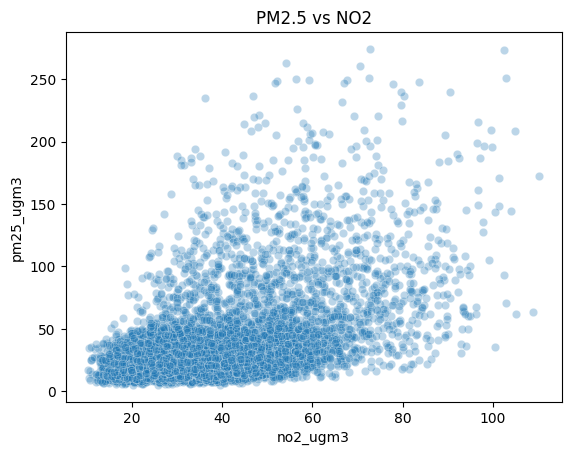

In [10]:
#Exploratory Data Analysis
# Summary stats
display(df.describe())

# Trend over time
avg_pm25 = df.groupby("year")["pm25_ugm3"].mean().reset_index()
px.line(avg_pm25, x="year", y="pm25_ugm3", title="Average PM2.5 over years")

# Countries having average 2.5PM highest
top_countries = df.groupby("country")["pm25_ugm3"].mean().nlargest(10).reset_index()
px.bar(top_countries, x="country", y="pm25_ugm3", title="Top 10 countries by avg PM2.5")

# Scatter PM2.5 vs NO2
sns.scatterplot(x="no2_ugm3", y="pm25_ugm3", data=df, alpha=0.3)
plt.title("PM2.5 vs NO2"); plt.show()




In [11]:
#Feature Engineering
# Encode month-season mapping
def get_season(month):
    if month in [12,1,2]: return "Winter"
    if month in [3,4,5]: return "Spring"
    if month in [6,7,8]: return "Summer"
    else: return "Autumn"

df["season"] = df["month"].apply(get_season)

# Drop unnecessary columns
features = ["latitude", "longitude", "year", "month", "no2_ugm3"]
target = "pm25_ugm3"

X = df[features]
y = df[target]

print("Feature sample:")
X.head()


Feature sample:


,latitude,longitude,year,month,no2_ugm3
0,40.7128,-74.006,1999,1,35.98
1,40.7128,-74.006,1999,2,17.71
2,40.7128,-74.006,1999,3,40.99
3,40.7128,-74.006,1999,4,17.18
4,40.7128,-74.006,1999,5,25.07


RMSE = 18.787
R² = 0.712
MAE = 12.363
RMSE = 18.787


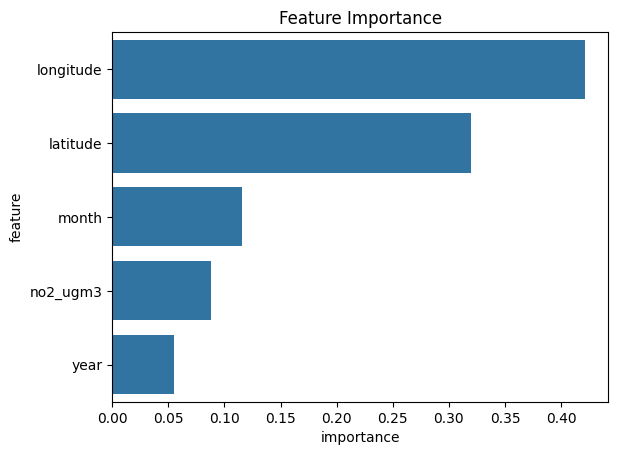

In [18]:
#Model Evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"RMSE = {rmse:.3f}")


r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R² = {r2:.3f}")
print(f"MAE = {mae:.3f}")
print(f"RMSE = {rmse:.3f}")

# Feature importance
imp = pd.DataFrame({
    "feature": X.columns,
    "importance": model.feature_importances_
}).sort_values("importance", ascending=False)
sns.barplot(x="importance", y="feature", data=imp)
plt.title("Feature Importance"); plt.show()


In [19]:
#Example Prediction
sample_input = X_test.sample(1, random_state=1)
predicted = model.predict(sample_input)[0]

print("Sample input:")
display(sample_input)
print(f"Predicted PM2.5: {predicted:.2f} µg/m³")

# Show which features contributed most
display(imp)

Sample input:


,latitude,longitude,year,month,no2_ugm3
8,40.7128,-74.006,1999,9,38.56


Predicted PM2.5: 15.72 µg/m³


,feature,importance
1,longitude,0.420875
0,latitude,0.319805
3,month,0.115880
4,no2_ugm3,0.088456
2,year,0.054984


In [22]:
import os

# Models folder create karo agar exist na kare
os.makedirs("/content/models", exist_ok=True)

In [24]:
import joblib

joblib.dump(model, "/content/models/random_forest_pm25.pkl")
print("Model saved successfully!")

Model saved successfully!


In [25]:
os.makedirs("/content/data", exist_ok=True)
df.to_csv("/content/data/cleaned_air_quality.csv", index=False)
print("CSV saved successfully!")

CSV saved successfully!


In [26]:
import joblib

df.to_csv("/content/cleaned_air_quality.csv", index=False)
joblib.dump(model, "/content/models/random_forest_pm25.pkl")

print("Files saved!")

Files saved!


In [27]:
from google.colab import files
files.download("cleaned_air_quality.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
from google.colab import files

files.download("/content/models/random_forest_pm25.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>